# Contenido <a id='back'></a>

* [Introducción](#intro)
* [Etapa 1. Inicialización](#inicializacion) 
* [Etapa 2. Cargar los datos](#cargar)
* [Etapa 3. Análisis de la calidad de los datos](#analisis)
    * [Corregir datos](#corregir)
* [Etapa 4. Análisis exploratorio de datos](#exploratorio)
* [Etapa 5. Construir un modelo para predecir la cancelación de usuarios](#modelo)
    * [Entrenar modelo con el método regresión logística](#logistica)
    * [Entrenar modelo con el método bosque aleatorio ](#bosque)
    * [Conclusiones](#conclusiones)
* [Etapa 6. Clústeres de usuarios ](#clusteres)
    * [Algoritmo K-means](k)
* [Conclusión general](#general)
* [Recomendaciones](#recomendaciones)

# ¿Cómo descubres que un cliente ya no está contigo? <a id='intro'></a>

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con el cliente basada en datos analíticos.
Con el fin de combatir la cancelación, Model Fitness ha digitalizado varios de sus perfiles de clientes. Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.


Esta investigación tiene como propósito aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente,
elaborar retratos de usuarios típicos, analizar los factores que más impactan la pérdida, sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente.

Se cuenta con un archivo CSV que contiene los datos sobre cancelación de un mes en concreto e información del mes que lo precedía, esto nos permitirá construir un modelo para predecir la cancelación de usuarios y crear clústeres de usuarios para obtener conclusiones y formular recomendaciones con respecto a la estrategia para la interacción y retención de clientes.

Se van a preparar los datos, comprobando si contienen valores ausentes o duplicados, modificar los tipos de datos si es necesario, enriquecer los datos agregando nuevas columnas para luego estudiar y comprobar los datos, formular hipótesis, 
seleccionar las métricas y el modelo de aprendizaje automático que se van a implementar, entrenar el modelo y evaluar los resultados.


## Inicialización <a id='inicializacion'></a>

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

## Cargar los datos <a id='cargar'></a>

In [3]:
data= pd.read_csv('/datasets/gym_churn_us.csv')


## Análisis de la calidad de los datos <a id='analisis'></a>

In [4]:
#Tamaño del dataset
data.shape

(4000, 14)

In [5]:
# Información general/resumen sobre el DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
# Muestra de los datos
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [7]:
# Comprobar si hay duplicados

print(data.duplicated().sum())
duplicated_data= data[data.duplicated()]

0


El dataset data contiene los siguientes campos:

- `gender` — género del cliente.
- `Near_Location ` — si el usuario vive o trabaja en el vecindario donde se encuentra el gimnasio        
- `Partner`  — si el usuario es un trabajador de una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes)  
- `Promo_friends` — si el usuario originalmente se inscribió mediante una oferta "trae a un amigo" (se utilizó el código promocional de un amigo cuando pagaron el primer abono).      
- `Phone`  — si el usuario aportó el número de teléfono  
- `Contract_period` — 1 mes, 3 meses, 6 meses o 1 año
- `Group_visits` — si el usuario participa en sesiones grupales.     
- `Age`  — Edad del cliente
- `Avg_additional_charges_total` — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc. 
- `Month_to_end_contract` — Meses para finalizar contrato.
- `Lifetime` — el tiempo (en meses) desde que el usuario llegó por primera vez al gimnasio        
- `Avg_class_frequency_total`  — frecuencia media de visitas por semana a lo largo de la vida del cliente  
- `Avg_class_frequency_current_month` — frecuencia media de visitas por semana durante el mes en curso
- `Churn` — la cancelación para el mes en cuestión.

Tenemos un conjunto de datos conformado por 14 columnas y 4000 filas, todas las características son numéricas, no se encontraton valores ausentes ni registros duplicados, 
Se ajustarán los nombres de las columnas para que solo contengan letras minúsculas. 

### Corregir datos<a id='corregir'></a>

In [8]:
# Cambiar nombre de las columnas

data.columns=['gender','near_location','partner','promo_friends','phone','contract_period','group_visits','age','avg_additional_charges_total','month_to_end_contract','lifetime','avg_class_frequency_total','avg_class_frequency_current_month','churn']


In [9]:
# Comprobar información general de la tabla 

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

## Análisis exploratorio de datos <a id='exploratorio'></a>

In [10]:
# valores promedio y la desviación estándar
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Se calcularon los valores promedios para cada característica y su respectiva desviación estándar y se puede observar lo siguiente:
- Tenemos 7 caracteristicas por debajo de 1 (gender, near_location, partner, promo_friends, phone, group_visits, avg_class_frequency_total, churn) lo que indica que los datos tienden a estar más cerca a la media.
- Las características contract_period, age, month_to_end_contract, lifetime, avg_class_frequency_current_month tienen valores por encima de 1 pero no son valores tan altos podemos decir que los datos no están tan dispersos.
- Por el contrario tenemos la característica avg_additional_charges_total que tiene una deviación estándar de 96.355602 lo que nos indica que los datos tienden a estar más lejos de la media por lo cual su dispersión es mayor.

In [11]:
#valores medios de las características en dos grupos: para los que se fueron (cancelación) y para los que se quedaron

data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Se calcularon los valores medios en función de la característica principal churn donde 0= no canceló la suscripción y 1= si canceló la suscripción y se notaron algunas características que se diferencian entre cada uno de los grupos:

- partner donde 0= no y 1= si, para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron son usuarios de una compañía asociada.
- promo_friends donde 0= no y 1 = si, para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron utilizaron el código promocional de un amigo cuando pagaron el primer abono.
- contract_period para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron contrataron planes de mayor cantidad de tiempo. 
- group_visits para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron participan mas en sesiones grupales.
- avg_additional_charges_total para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron gastaron más dinero en otros servicios del gimnasio.
- month_to_end_contract para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron les falta más tiempo para finalizar el contrato.
- lifetime para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron ya superaron el primer mes desde que llegaron por primera vez al gimnasio.
- avg_class_frequency_total para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron tienen una frecuencia mayor de visitas por semana a lo largo de la vida del cliente.
- avg_class_frequency_current_month para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron tienen una frecuencia mayor de visitas durante el mes en curso.
 

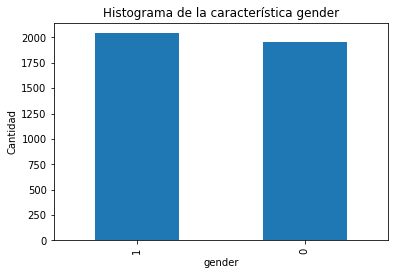

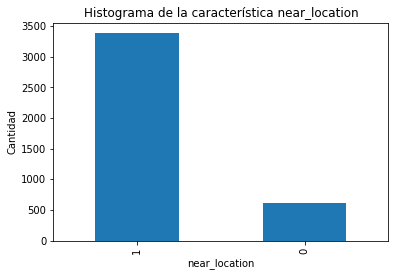

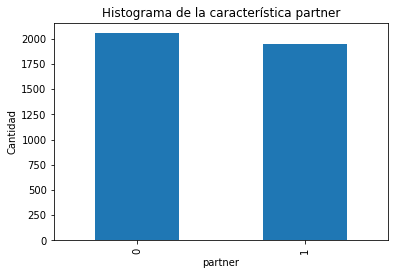

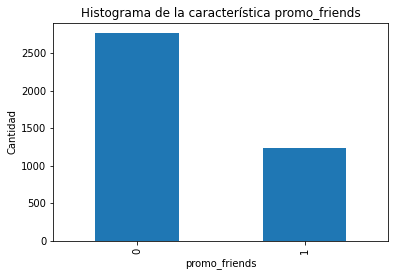

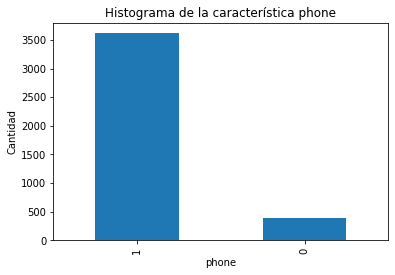

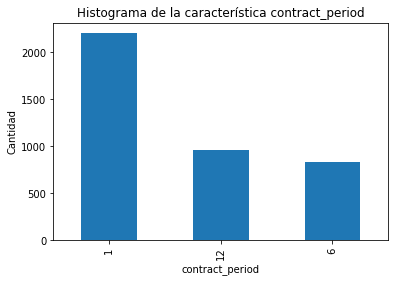

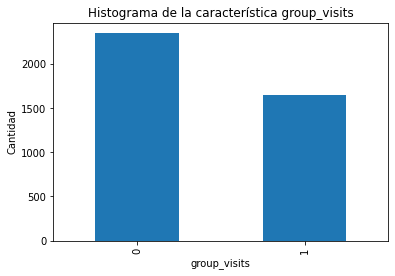

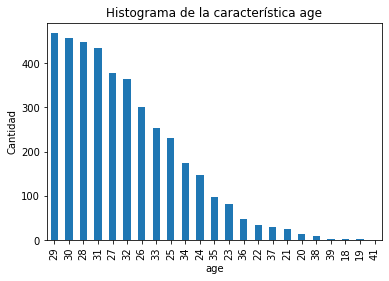

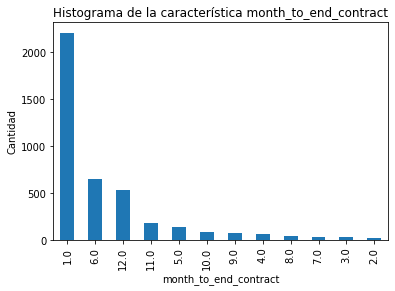

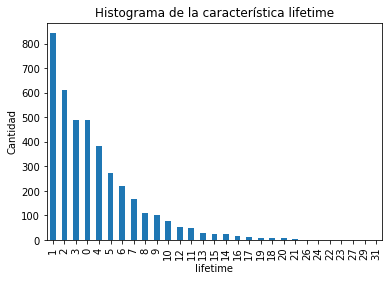

In [12]:
# Diagramas de barras de barra 

for col in data.drop(['churn','avg_additional_charges_total','avg_class_frequency_total','avg_class_frequency_current_month'], axis=1).columns:
    grafico= data[col].value_counts()
    grafico.plot(kind='bar', title= f'Histograma de la característica {col}')
    plt.xlabel(col)
    plt.ylabel('Cantidad')
    plt.show()


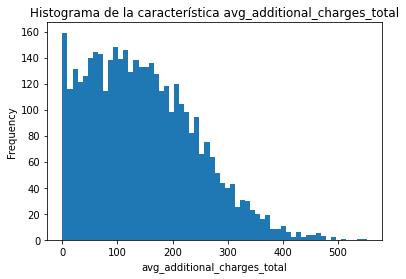

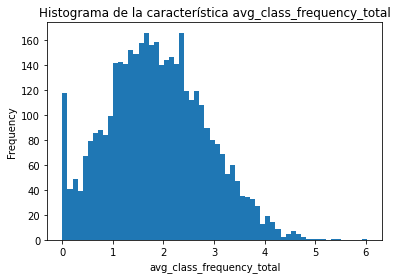

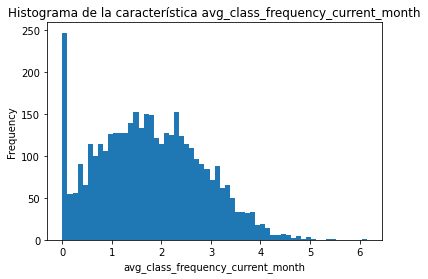

In [13]:
for col in data.drop(['churn','gender','near_location','partner','promo_friends','phone','age','contract_period','month_to_end_contract','group_visits','lifetime'], axis=1).columns:
    data[col].plot(kind='hist', title= f'Histograma de la característica {col}', bins=60)
    plt.xlabel(col)
    plt.show()

Se realizaron diagramas de barras y  histogramas de barras para determinar la cantidad y frecuencia de las características del conjunto de datos y se obtuvieron los siguientes resultados:

- Gender: la cantidad de clientes está bastante equilibrada pero se observan un poco más de clientes representados por el número 1, no se observan valores atípicos.
- Near_location: la cantidad de clientes que vive o trabaja cerca del vencidario es notablemente mayor, no se observaron valores atípicos. 
- Patner: la cantidad de clientes que no trabaja en una empresa asociada es ligeramente mayor que la cantidad de clientes que si son empleados de las empresas asociadas.
- Promo_friends: La cantidad de cientes que no se inscribió mediante la oferta de trae a un amigo es mayor que los que si lo hicieron.
- Phone: la mayoría de los clientes proporcionó su número telefónico.
- Contract_period: La mayoría de los clientes realiza un contrato mensual, seguido por 12 meses y por último 6 meses. 
- Group_visits: La mayortía de las personas no realiza sesiones grupales.
- Age: tenemos una línea de distribución ajustada donde el pico mayor se encuentra cercano a los 30 años, a partir de ahí los valores comienzan a viajar, tenemos algunos valores atípicos menores a 20 años y otros que están cerca de los 40 años y más.
- Avg_additional_charges_total: la mayoría de los clientes no gasta en servicios adicionales o gasta muy poco cercano al 0, también tenemos una gran cantidad de valores que están entre los 100 y 200 y a partir de ahí los valores comienzan a bajar, se tienen algunos valores atípicos que llegan a superar los 500, también se observa una gran dispersión de los datos.
- A La mayoría de los clientes les falta 1 mes para que expire su contrato.
- Lifetime: La mayoría de los clientes tienen 1 mes desde que llegaron por primera vez al gimnasio, a medida que pasan los meses del ciclo de vida disminuye la cantidad de clientes. Se observan valores atípicos con clientes que llegan a tener hasta mas de 25 meses. 
- Avg_class_frequency_total: la frecuencia media de visitas por semana a lo largo de la vida del cliente está cercano a 1,5 y 2,5, se observan valores atípicos cercanos a 5 visitas y hasta 6 visitas. 
- Avg_class_frequency_current_month: la frecuencia media de visitas por semana durante el mes en curso tiene su pico más alto en el 0, luego tenemos otros picos que están entre 1,5 y 2,5 visitas, se observan valores a típicos cercanos a 5 visitas y hasta 6 visitas.

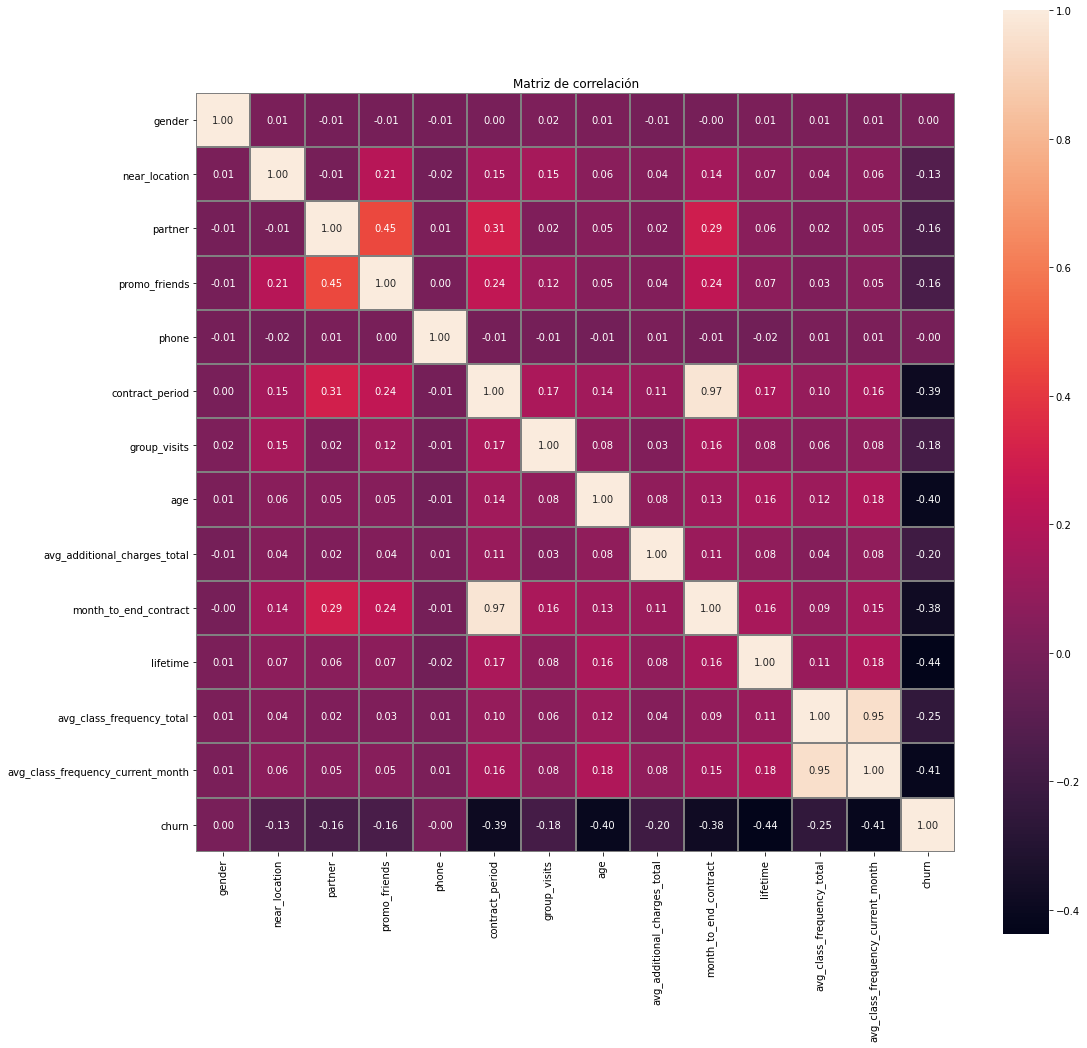

In [14]:
# matriz de correlación
cm= data.corr()
# mapa de calor para mostrar la matriz de correlación

plt.figure(figsize=(17, 17))
plt.title('Matriz de correlación')
sns.heatmap(
    cm,
    annot=True,
    square=True,
    linewidths=1,
    linecolor='gray',
    fmt='.2f'
) 
plt.show()

- El mapa de calor nos muestra que la variable objetivo solo está algo correlacionada inversamente con las otras características, es decir, a medida que una columna aumenta su valor en la otra disminuye y viceversa y solo está relacionada con ella misma.
- Month_to_end_contract y Contract_period  están muy furtemente relacionadas.
- Avg_class_frequency_current_month y Avg_class_frequency_total están muy fuertemente correlacionadas.

## Construir un modelo para predecir la cancelación de usuarios <a id='modelo'></a>

In [15]:
# Función para calcular métricas
def print_all_metrics(y_true, y_pred, y_proba, title = 'Métricas de clasificación'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [16]:
# Dividir los datos en características (Matriz X) Y variable objetivo(y) con la proporción 80-20
X= data.drop('churn', axis=1)
y= data['churn']

In [17]:
# Dividir los datos en conjunto de entrenamiento y validacion 

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=0)

In [18]:
# entrena StandardScaler en el conjunto de entrenamiento
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [19]:
# transforma conjuntos de entrenamiento y de prueba
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

### Entrenar modelo con el método regresión logística <a id='logistica'></a>

Se utiliza el algoritmo de regresión logística, para resolver tareas de clasificación binaria y permite estimar la probabilidad de un evento, en este caso si el cliente se queda o se va. 

In [20]:
# define el algoritmo para el modelo de regresión logística
lr_model = LogisticRegression(random_state=0)

In [21]:
# entrena el modelo 
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0)

In [22]:
# utiliza el modelo entrenado para hacer previsiones
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [23]:
# imprime todas las métricas
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Métricas para regresión logística:')

Métricas para regresión logística:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	ROC_AUC: 0.97


### Entrenar modelo con el método bosque aleatorio <a id='bosque'></a>

Se utiliza el algoritmo de bosque aleatorio ya que se puede utilizar para tareas de clasificación, tiene gran capacidad para de combinar los resultados de sus árboles para obtener un resultado final más fiable, es muy utilizado para predecir el comportamiento de los clientes.

In [24]:
# define el algoritmo para el nuevo modelo de random forest
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

In [25]:
#### entrena el modelo de random forest
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [26]:
# utiliza el modelo entrenado para hacer previsiones
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [27]:
# imprime todas las métricas
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Métricas para random forest:')

Métricas para random forest:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	ROC_AUC: 0.97


### Conclusiones <a id='conclusiones'></a>

Ambos modelos obtuvieron resulados con metricas por encima del 80%, ambos modelos son adecuados para la tarea pero segun los datos de las metricas la regresión logística es la mas conveniente:

- La métrica Accuracy indica que el 92% de los clientes fueron clasificados correctamente en ambos modelos.
- La regresión logística (85%) se destaca ya que el valor de Precision es mejor que la obtenida con el método bosque aleatorio(84%), esta métrica nos dice que proporción en la clase 1 es verdadero, lo que es bueno ya que si se van a tomar medidas como por ejemplo crear promociones especiales para estos clientes no queremos que el modelo alerte sin ningún motivo y se pierdan recursos.
- La regresión Logística (83%) también tiene mejores número para la métrica Reccal en comparación con el bosque aleatorio(81%), aplicando el modelo de regresión logística nos asegura que del 85% de los clientes que fueron clasificados como verdaderos con la métrica de Precision el 83% de los casos fueron identificados correctamente como positivos. 

## Clústeres de usuarios<a id='clusteres'></a>

In [28]:
# estandarizar los datos
sc = StandardScaler()
x_sc = sc.fit_transform(data)

In [29]:
# matriz de distancias
linked= linkage(x_sc, method = 'ward')

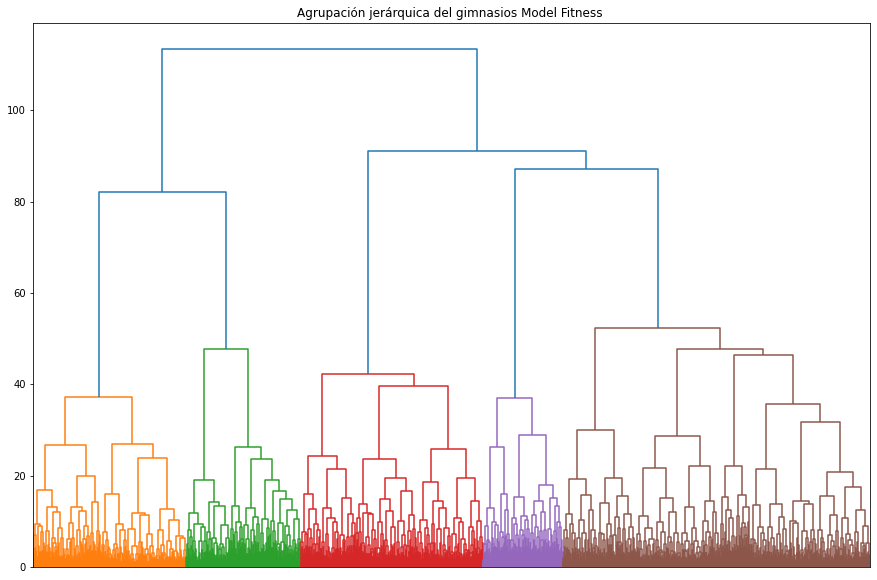

In [30]:
# graficar dendrograma para obtener número de clústeres

plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Agrupación jerárquica del gimnasios Model Fitness ')
plt.show()

La información del dendrograma nos indica que el número de clústeres sugerido es 5 corresponde a los cinco colores diferentes del gráfico. Ya que tenemos el número de clústeres podemos aplicar el algoritmo K-means

### Algoritmo K-means <a id='k'></a>

In [31]:
# definir el modelo k_means con 5 clústeres
km = KMeans(n_clusters=5)

In [32]:
# aplicar el algoritmo a los datos y formar un clúster
labels = km.fit_predict(x_sc)

In [33]:
# almacenar etiquetas de clúster en el campo de nuestro conjunto de datos
data['cluster_km'] = labels

In [34]:
# obtener las estadísticas de los valores medios de las características por clúster
cluster_km_= data.groupby(['cluster_km']).mean()

In [35]:
cluster_km_

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.524804,0.866841,0.469974,0.308094,0.000000,4.806789,0.428198,29.331593,144.156967,4.493473,3.945170,1.855107,1.723740,0.263708
1,0.475638,0.827146,0.447796,0.254060,1.000000,2.647332,0.381671,30.010441,153.532535,2.464037,4.674014,1.180614,1.179787,0.001160
2,0.550059,0.840989,0.374558,0.215548,0.998822,2.750294,0.441696,29.984688,160.178822,2.528857,4.588928,2.930098,2.936773,0.007067
3,0.503106,0.938923,0.768116,0.564182,1.000000,11.173913,0.557971,29.899586,161.514913,10.223602,4.704969,2.006679,2.001081,0.015528
4,0.507447,0.760638,0.341489,0.179787,0.997872,1.567021,0.257447,26.908511,115.109065,1.513830,0.976596,1.448700,1.026250,0.997872


Los clientes que se encuentran dentro del clúster 4 tienen en promedio un valor churn muy cercano a 1 lo que indica que la mayoría de los integrantes de este grupo cancela su contrato.

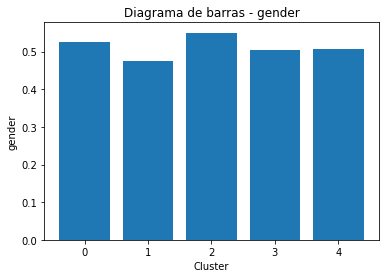

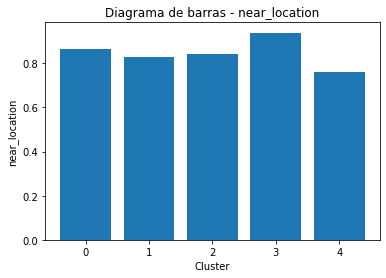

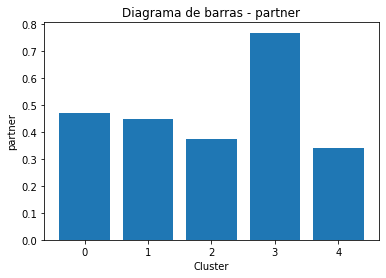

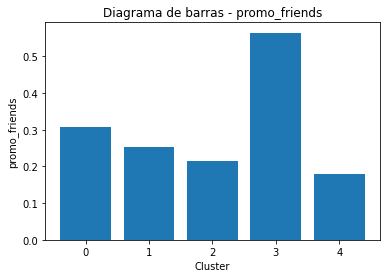

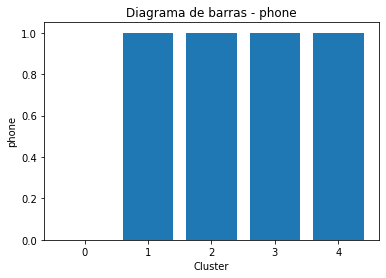

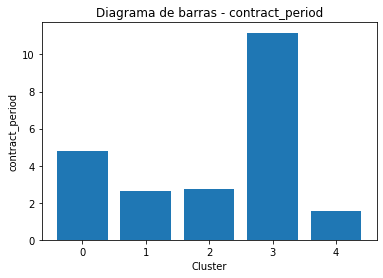

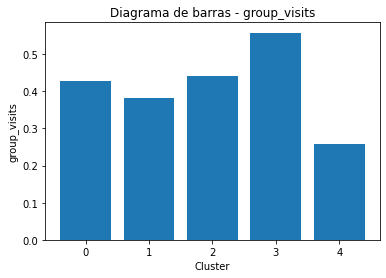

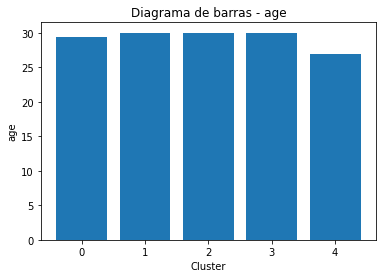

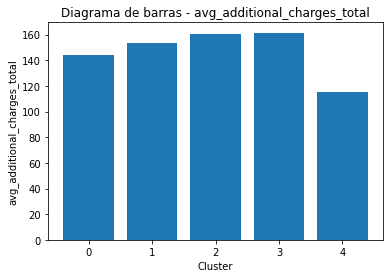

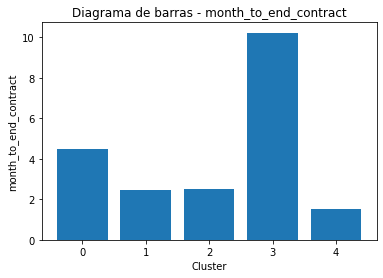

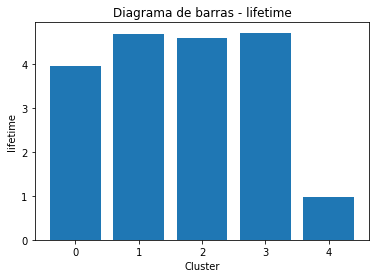

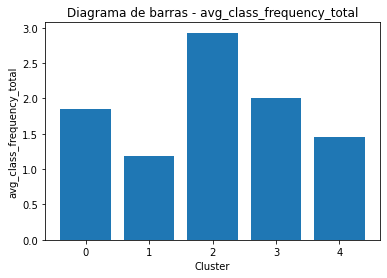

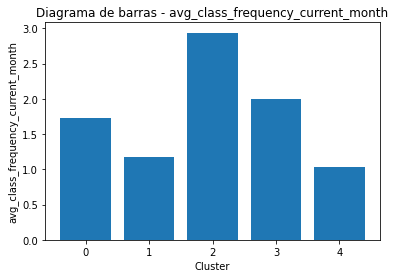

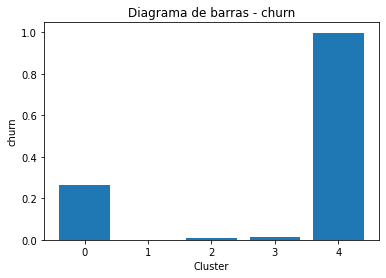

In [39]:
# Crear el diagrama de barras para cada columna
for column in cluster_km_.columns:
    plt.figure()
    plt.bar(cluster_km_.index, cluster_km_[column])
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.title(f'Diagrama de barras - {column}')
    plt.show()

Se estudió más de cerca las características de los grupos a través de histogramas de distribución y podemos ver que el grupo 4 se diferencia de los demás en las siguientes características:

- Partner: El grupo 4 tiene la menor cantidad de clientes que trabajan en una compañía asociada.
- Phone: Todos los clientes proporcionaron número de teléfono.
- Promo_friends: El grupo 4 tiene la menor cantidad de usuarios que se inscribieron con la oferta de trae a un amigo.
- Contract_period: en el grupo 4 están aquellos usuarios que adquirieron contratos con la duración mas corta.
- Group_visits: En el grupo 4 están aquellos clientes que menos participan en clases grupales.
- Age- La edad de los clientes del grupo 4 son menores de 30 años.
- Avg_additional_charges_total: Los clientes del grupo 4 gastan menos dinero en otros servicios del gimnasio.
- Month_to_end_contract: A Los clientes del grupo 4 les falta menos de 2 meses para terminar su contrato.
- Los integrantes del grupo 4 tienen un ciclo de vida de 1 mes.
- Avg_class_frequency_total y vg_class_frequency_current_month: La frecuencia promedio con la que concurren al gimnasio tanto a lo largo de todo su ciclo de vida como del mes en curso es menor a 1,5.
- Churn: El grupo 4 es el que contiene la mayoría de los clientes que abandonaron el gimnasio. 


In [40]:
# tasa de cancelación para cada clúster

churn_rate= data.groupby('cluster_km')['churn'].value_counts().to_frame()
churn_rate.columns=['count_churn']
churn_rate.reset_index(inplace=True)
churn_rate['churn_rate'] = (churn_rate['count_churn'] / 4000) * 100

In [41]:
# subconjunto con los clientes que abandonaron
churn_rate_1=churn_rate[(churn_rate['churn']==1)]
churn_rate_1

,cluster_km,churn,count_churn,churn_rate
1,0,1,101,2.525
3,1,1,1,0.025
5,2,1,6,0.150
7,3,1,15,0.375
8,4,1,938,23.450


Los clientes mas propensos a irse son los que integran el grupo 4 con una tasa de cancelación del 23.450%, mientras que los grupos con las tasas mas bajas son los grupos 1,2 y 3 donde las tasas no llegas al 1%.

## Conclusiones Generales <a id='general'></a>

El estudio se basó en el análisis de un dataset con los datos de los clientes de la cadena de gimnasios Model Fitness sobre la cancelación de una mes en concreto así como la información del mes que lo precedía, entre los datos se tiene: el género, edad, teléfono, si los clientes llegaron a través de la promo amigos, los gastos adicionales en otros servicios del gimnasio, meses de contrato y ciclo de vida del cliente, entre otros. El conjunto de datos estaba conformado por 14 columnas y 4000 filas, todas las características eran numéricas y no se encontraton valores ausentes ni registros duplicados, solo se ajustaron los nombres de las columnas para que solo contengan letras minúsculas.

Se calcularon los valores promedios para cada característica y su respectiva desviación estándar y se puede observar lo siguiente:
- Tenemos 7 caracteristicas por debajo de 1 (gender, near_location, partner, promo_friends, phone, group_visits, avg_class_frequency_total, churn) lo que indica que los datos tienden a estar más cerca a la media.
- Las características contract_period, age, month_to_end_contract, lifetime, avg_class_frequency_current_month tienen valores por encima de 1 pero no son valores tan altos podemos decir que los datos no están tan dispersos.
- Por el contrario tenemos la característica avg_additional_charges_total que tiene una deviación estándar de 96.355602 lo que nos indica que los datos tienden a estar más lejos de la media por lo cual su dispersión es mayor.

Se calcularon los valores medios en función de la característica principal churn donde 0= no canceló la suscripción y 1= si canceló la suscripción y se notaron algunas características que se diferencian entre cada uno de los grupos:

- partner donde 0= no y 1= si, para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que en promedio los que se quedaron son usuarios de una compañía asociada.

- promo_friends donde 0= no y 1 = si, para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que en promedio los que se quedaron utilizaron el código promocional de un amigo cuando pagaron el primer abono.

- contract_period para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron contrataron planes de mayor cantidad de tiempo. 

- group_visits para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron participan mas en sesiones grupales.

- avg_additional_charges_total para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron gastaron más dinero en otros servicios del gimnasio.

- month_to_end_contract para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron les falta más tiempo para finalizar el contrato.

- lifetime para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron ya superaron el primer mes desde que llegaron por primera vez al gimnasio.

- avg_class_frequency_total para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron tienen una frecuencia mayor de visitas por semana a lo largo de la vida del cliente.

- avg_class_frequency_current_month para los que se quedaron podemos decir que la media es mayor que los que no se quedaron por lo que podemos decir que en promedio los que se quedaron tienen una frecuencia mayor de visitas durante el mes en curso.

Se realizaron diagramas de barras y histogramas para determinar la  cantidad y frecuencia de cada una de las características del conjunto de datos y se obtuvieron los siguientes resultados:

- Gender: la cantidad de clientes está bastante equilibrada pero se observan un poco más de clientes representados por el número 1, no se observan valores atípicos.
- Near_location: la cantidad de clientes que vive o trabaja cerca del vencidario es notablemente mayor, no se observaron valores atípicos. 
- Patner: la cantidad de clientes que no trabaja en una empresa asociada es ligeramente mayor que la cantidad de clientes que si son empleados de las empresas asociadas.
- Promo_friends: La cantidad de cientes que no se inscribió mediante la oferta de trae a un amigo es mayor que los que si lo hicieron.
- Phone: la mayoría de los clientes proporcionó su número telefónico.
- Contract_period: La mayoría de los clientes realiza un contrato mensual, seguido por 12 meses y por último 6 meses. 
- Group_visits: La mayortía de las personas no realiza sesiones grupales.
- Age: tenemos una línea de distribución ajustada donde el pico mayor se encuentra cercano a los 30 años, a partir de ahí los valores comienzan a viajar, tenemos algunos valores atípicos menores a 20 años y otros que están cerca de los 40 años y más.
- Avg_additional_charges_total: la mayoría de los clientes no gasta en servicios adicionales o gasta muy poco cercano al 0, también tenemos una gran cantidad de valores que están entre los 100 y 200 y a partir de ahí los valores comienzan a bajar, se tienen algunos valores atípicos que llegan a superar los 500, también se observa una gran dispersión de los datos.
- A La mayoría de los clientes les falta 1 mes para que expire su contrato.
- Lifetime: La mayoría de los clientes tienen 1 mes desde que llegaron por primera vez al gimnasio, a medida que pasan los meses del ciclo de vida disminuye la cantidad de clientes. Se observan valores atípicos con clientes que llegan a tener hasta mas de 25 meses. 
- Avg_class_frequency_total: la frecuencia media de visitas por semana a lo largo de la vida del cliente está cercano a 1,5 y 2,5, se observan valores atípicos cercanos a 5 visitas y hasta 6 visitas. 
- Avg_class_frequency_current_month: la frecuencia media de visitas por semana durante el mes en curso tiene su pico más alto en el 0, luego tenemos otros picos que están entre 1,5 y 2,5 visitas, se observan valores a típicos cercanos a 5 visitas y hasta 6 visitas.

Se realizó un mapa de calor con la correlación de las características:

- El mapa de calor nos muestra que la variable objetivo solo está algo correlacionada inversamente con las otras características, es decir, a medida que una columna aumenta su valor en la otra disminuye y viceversa y solo está relacionada con ella misma.
- Month_to_end_contract y Contract_period  están muy furtemente relacionadas.
- Avg_class_frequency_current_month y Avg_class_frequency_total están muy fuertemente correlacionadas.

Se utilizaron los modelos  de regresión logística y bosque aletario y se obtuvieron los siguientes resultados:

Ambos modelos obtuvieron resulados con metricas por encima del 80%, ambos modelos son adecuados para la tarea pero segun los datos de las metricas la regresión logística es la mas conveniente:

- La métrica Accuracy indica que el 92% de los clientes fueron clasificados correctamente en ambos modelos.
- La regresión logística (85%) se destaca ya que el valor de Precision es mejor que la obtenida con el método bosque aleatorio(84%), esta métrica nos dice que proporción en la clase 1 es verdadero, lo que es bueno ya que si se van a tomar medidas como por ejemplo crear promociones especiales para estos clientes no queremos que el modelo alerte sin ningún motivo y se pierdan recursos.
- La regresión Logística (83%) también tiene mejores número para la métrica Reccal en comparación con el bosque aleatorio(81%), aplicando el modelo de regresión logística nos asegura que del 85% de los clientes que fueron clasificados como verdaderos con la métrica de Precision el 83% de los casos fueron identificados correctamente como positivos. 

Se utilizó el algoritmo K-means con 5 clústeres para agrupar los clientes y verificar cual de los grupos tiene mayor probabilidad de abandono y se determinó lo siguiente:

- Los clientes que se encuentran dentro del clúster 4 tienen en promedio un valor churn muy cercano a 1 lo que indica que la mayoría de los integrantes de este grupo cancela su contrato.

Se estudió más de cerca las características de los grupos a través de histogramas de distribución y podemos ver que el grupo 4 se diferencia de los demás en las siguientes características:

- Partner: El grupo 4 tiene la menor cantidad de clientes que trabajan en una compañía asociada.

- Phone: Todos los clientes proporcionaron número de teléfono.

- Promo_friends: El grupo 4 tiene la menor cantidad de usuarios que se inscribieron con la oferta de trae a un amigo.

- Contract_period: en el grupo 4 están aquellos usuarios que adquirieron contratos con la duración mas corta.

- Group_visits: En el grupo 4 están aquellos clientes que menos participan en clases grupales.

- Age- La edad de los clientes del grupo 4 son menores de 30 años.

- Avg_additional_charges_total: Los clientes del grupo 4 gastan menos dinero en otros servicios del gimnasio.

- Month_to_end_contract: A Los clientes del grupo 4 les falta menos de 2 meses para terminar su contrato.
- Los integrantes del grupo 4 tienen un ciclo de vida de 1 mes.

- Avg_class_frequency_total y vg_class_frequency_current_month: La frecuencia promedio con la que concurren al gimnasio tanto a lo largo de todo su ciclo de vida como del mes en curso es menor a 1,5.

- Churn: El grupo 4 es el que contiene la mayoría de los clientes que abandonaron el gimnasio.


## Recomendaciones <a id='recomendaciones'></a>

1. Enfocarse en aquellos clientes que se encuentran en el primer mes de su ciclo de vida principalmente, ya que los abandonos son muy posibles en este mes.
2. Enfocarse en aquellos clientes menores de 30 años. 
3. Ya que la mayoría de los clientes que no se quedaron no participan en clases grupales y los que se quedaron si lo hacen se podría tratar de incentivar a los clientes a participar en estas clases. 
4. Ya que una gran cantidad de clientes que se inscribieron con la oferta trae un amigo no abandonaron sería buena idea enfocarse y publicitar esta promoción o promociones parecidas, ya que así como las clases grupales influyen en el no abandono es muy probable que ir acompañado influya también en la decisión de quedarse o no. 
5. Asociarse con más compañías para que sus empleados asistan al gimnasio ya estos clientes tienen menos probabilidades de abandono. 